Иморитирование библиотек

In [192]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Смотрим исходные данные

In [193]:
train = pd.read_csv("df/train.csv", low_memory=False)
valid = pd.read_csv("df/valid.csv", low_memory=False)

arr = [train, valid]
names_df = ['train', 'valid']

def perenos():
     if i == 0:
          print('\n*******************************************************************************\n')

for i, elem in enumerate(arr):
     # Вывод info для просмотра типов табл и их колво
     print(f'Инфо {names_df[i]}')
     elem.info()

     # Вывод строк + столб кол-во
     print(f"\n{names_df[i]} имеет: {elem.shape} (строк, столбцов)")

     # Выводим колонки с разными типами данных
     numeric_columns = elem.select_dtypes(include=['int64', 'float64']).columns
     categorical_columns = elem.select_dtypes(include=['object']).columns
     boolean_columns = elem.select_dtypes(include=['bool']).columns

     print(f"\nЧисловые колонки в {names_df[i]}: {len(numeric_columns)}")
     print(f"Категориальные колонки в {names_df[i]}: {len(categorical_columns)}")
     print(f"Булевые колонки в {names_df[i]}: {len(boolean_columns)}")

     perenos()

Инфо train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB

train имеет: (14456, 2666) (строк, столбцов)

Числовые колонки в train: 2319
Категориальные колонки в train: 347
Булевые колонки в train: 0

*******************************************************************************

Инфо valid
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 2666 entries, report_date to col2663
dtypes: float64(2329), int64(3), object(334)
memory usage: 74.1+ MB

valid имеет: (3642, 2666) (строк, столбцов)

Числовые колонки в valid: 2332
Категориальные колонки в valid: 334
Булевые колонки в valid: 0


In [194]:
train.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [195]:
valid.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


Смотрим пропущенные значения

In [196]:
# Вывод пропущ. знач
for i, elem in enumerate(arr):
    print(f"Число пропущенных значений в {names_df[i]}:")
    print(elem.isna().sum())
    perenos()

Число пропущенных значений в train:
report_date        0
client_id          0
target             0
col1           14453
col2           14450
               ...  
col2659        13950
col2660         6420
col2661         6420
col2662         6420
col2663            0
Length: 2666, dtype: int64

*******************************************************************************

Число пропущенных значений в valid:
report_date       0
client_id         0
target            0
col1           3642
col2           3640
               ... 
col2659        3578
col2660        1280
col2661        1280
col2662        1280
col2663           0
Length: 2666, dtype: int64


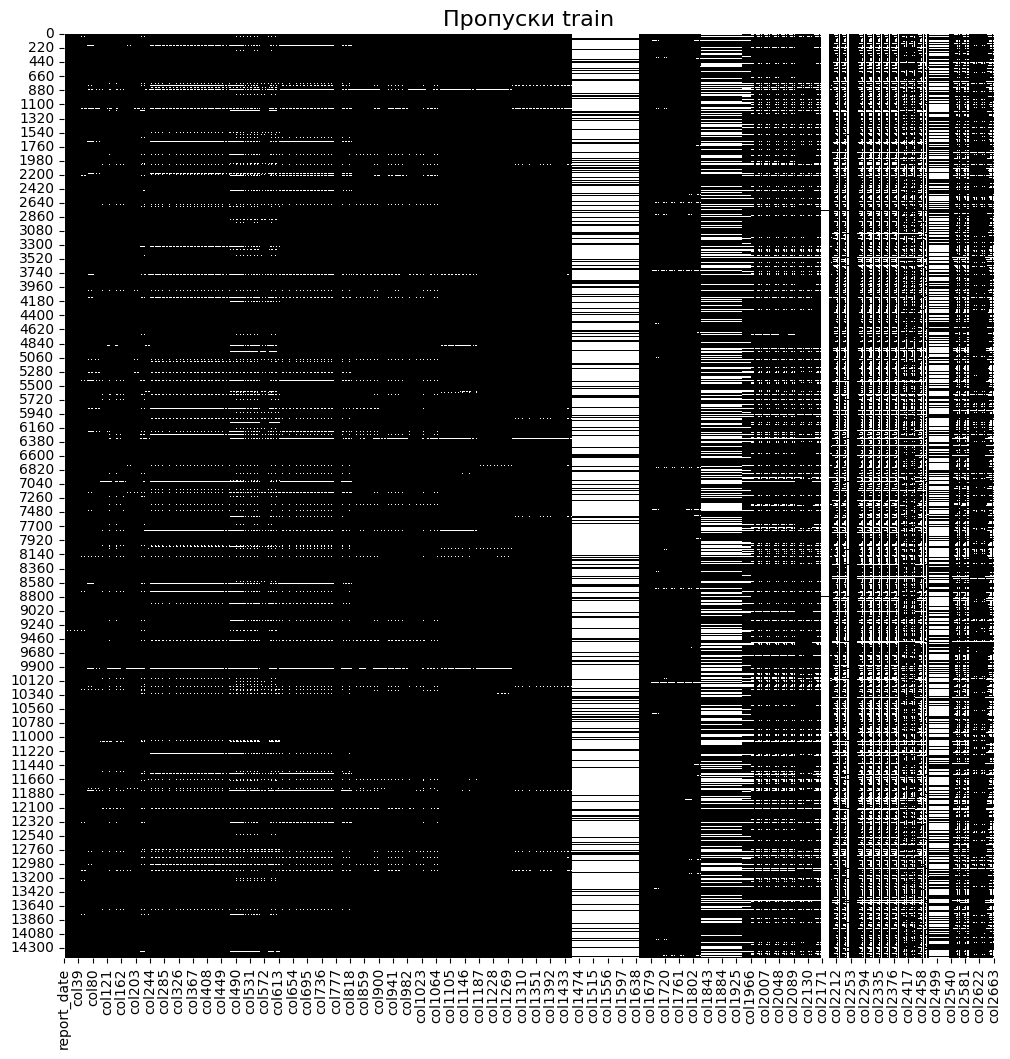

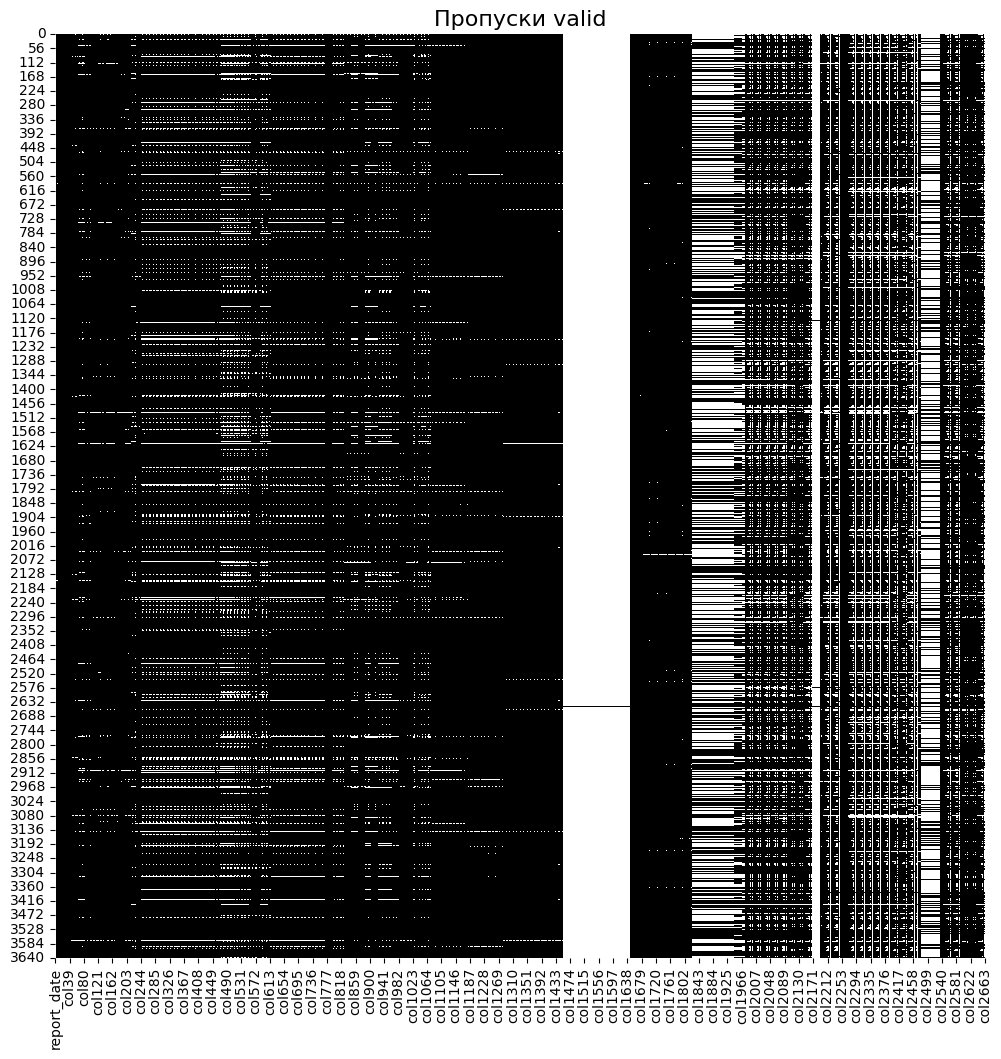

In [197]:
for i, elem in enumerate(arr): 
      fig, ax = plt.subplots(figsize=(12, 12))
      sns.heatmap(elem.isnull(), cbar = False, cmap = 'Greys')
      plt.title(f"Пропуски {names_df[i]}", fontsize=16)
      plt.show()

Обработка (IQR межквартильный размах)

In [198]:
def iqr_remove(df, columns=None, threshold=3):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns
    
    df_clean = df.copy()
    for col in columns:
            Q1 = df[col].quantile(0.25)  
            Q3 = df[col].quantile(0.75)  
            IQR = Q3 - Q1  
        
            lower_bound = Q1 - threshold * IQR  
            upper_bound = Q3 + threshold * IQR
        
            # Фильтрация данных: оставить только значения в допустимых пределах
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    return df_clean

for i, elem in enumerate(arr):
    # Удаление аномалий из всех числовых столбцов
    cleaned = iqr_remove(elem)

    # Проверка результатов
    print(f"{names_df[i]} до удаления аномалий:", elem.shape)
    print(f"{names_df[i]} после удаления аномалий:", cleaned.shape)

    cleaned.to_csv(f'df/_{names_df[i]}_updt.csv', index=False)
    print("Данные успешно сохранены.")

    perenos()

train до удаления аномалий: (14456, 2666)
train после удаления аномалий: (0, 2666)
Данные успешно сохранены.

*******************************************************************************

valid до удаления аномалий: (3642, 2666)
valid после удаления аномалий: (0, 2666)
Данные успешно сохранены.


In [199]:
train.head(5)

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [200]:
valid.head(5)

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


In [201]:
# Проверка, совпадают ли структуры
def check_struktura(arr):
    if sorted(arr[0].columns) != sorted(arr[1].columns):
        raise ValueError("Структуры не совпадают!")
    else:
        print("Структуры совпадают.")

threshold = 0.75

# Рассчитаем долю пропусков
train_missing_fraction = train.isnull().mean()
valid_missing_fraction = valid.isnull().mean()

# Рассчитаем максимальную долю пропусков
combined_missing_fraction = pd.concat([train_missing_fraction, valid_missing_fraction], axis=1).max(axis=1)

# Определяем колонки для удаления
columns_to_drop = []
for col in combined_missing_fraction.index:
    if combined_missing_fraction[col] > threshold:
        columns_to_drop.append(col)

# Удаляем колонки с большим количеством пропусков
train_updt = train.drop(columns=columns_to_drop)
valid_updt = valid.drop(columns=columns_to_drop)

arr_updt = [train_updt, valid_updt]
names_df_updt = ['train_updt', 'valid_updt']

check_struktura(arr)
print()

# Проверка наличия одновременно float и object
def has_mixed_types(column):
    types = set(column.dropna().map(type))
    return float in types and str in types

# Определяем колонки с разными типами данных
for i, elem in enumerate(arr_updt):
    mixed_type_columns = []
    for col in elem.columns:
        if has_mixed_types(elem[col]):
            mixed_type_columns.append(col)

    if names_df_updt[i] == 'train_updt':
        mixed_type_columns_train = mixed_type_columns
    elif names_df_updt[i] == 'valid_updt':
        mixed_type_columns_valid = mixed_type_columns

# Удаляем эти колонки из обоих наборов данных
columns_to_drop_mixed = set(mixed_type_columns_train).union(mixed_type_columns_valid)
train_updt = train_updt.drop(columns=columns_to_drop_mixed)
valid_updt = valid_updt.drop(columns=columns_to_drop_mixed)

check_struktura(arr_updt)

for i, elem in enumerate(arr_updt):
    print(f"\n{names_df_updt[i]} имеет: {elem.shape} (строк, столбцов)")

Структуры совпадают.

Структуры совпадают.

train_updt имеет: (14456, 490) (строк, столбцов)

valid_updt имеет: (3642, 490) (строк, столбцов)


In [202]:
for i, elem in enumerate(arr_updt):
    for col in elem.columns:
        if elem[col].dtype in ['float64', 'int64']:
            elem[col] = elem[col].fillna(elem[col].median()) # Заполнение медианой
        elif elem[col].dtype == 'object':
            elem[col] = elem[col].fillna('unknown') # Заполнение unknown

check_struktura(arr_updt)

for i, elem in enumerate(arr_updt):
    elem.to_csv(f'df/_{names_df_updt[i]}.csv', index=False)
    print("Данные успешно сохранены.")

Структуры совпадают.
Данные успешно сохранены.
Данные успешно сохранены.


In [203]:
train_updt.head(3)

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,0,00f3d719-a6ec-4960-ba01-8372eb705443,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,1,01febac0-b083-494e-8589-f98400074b94,0.0,0.0,0.0,0.0,0.0,...,362.0,362.0,362.0,7616803.0,7616803.0,7616803.0,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,0,0278175e-c0bb-4e1e-bfe5-20db6811d3e2,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261


In [204]:
valid_updt.head(3)

,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,...,col2588,col2589,col2590,col2654,col2655,col2656,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,0,01016bd5-10dc-ec11-b823-005056b825cd,0.0,0.0,0.0,0.0,0.0,...,240.0,240.0,240.0,4941670.0,4941670.0,4941670.0,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,0,0151dccf-0ecb-ed11-b828-005056b81dee,0.0,0.0,1.0,1.0,1.0,...,360.0,360.0,360.0,11789500.0,11789500.0,11789500.0,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,0,074ce8a6-859a-4084-a1c6-41343a94a856,0.0,0.0,0.0,0.0,0.0,...,348.0,348.0,348.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,7000000.0,0.257217


Смотрим значения после обработки.

In [205]:
for i, elem in enumerate(arr_updt):
    print(f"Число пропущенных значений в датасете {names_df_updt[i]} после обработки:")
    print(elem.isna().sum())
    print(f"\nДатасет {names_df_updt[i]} после обработки имеет: {elem.shape}")
    
    perenos()

Число пропущенных значений в датасете train_updt после обработки:
report_date    0
client_id      0
target         0
col1453        0
col1454        0
              ..
col2656        0
col2660        0
col2661        0
col2662        0
col2663        0
Length: 490, dtype: int64

Датасет train_updt после обработки имеет: (14456, 490)

*******************************************************************************

Число пропущенных значений в датасете valid_updt после обработки:
report_date    0
client_id      0
target         0
col1453        0
col1454        0
              ..
col2656        0
col2660        0
col2661        0
col2662        0
col2663        0
Length: 490, dtype: int64

Датасет valid_updt после обработки имеет: (3642, 490)


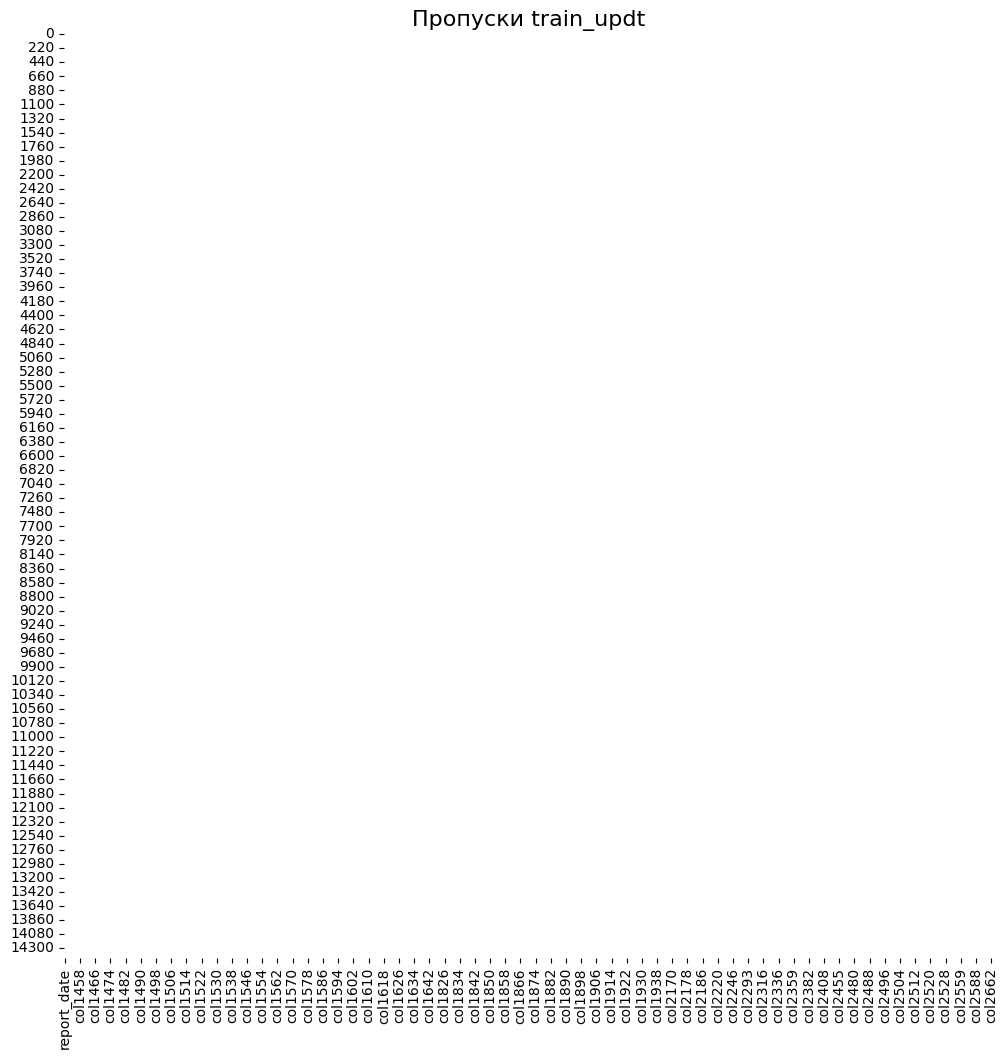

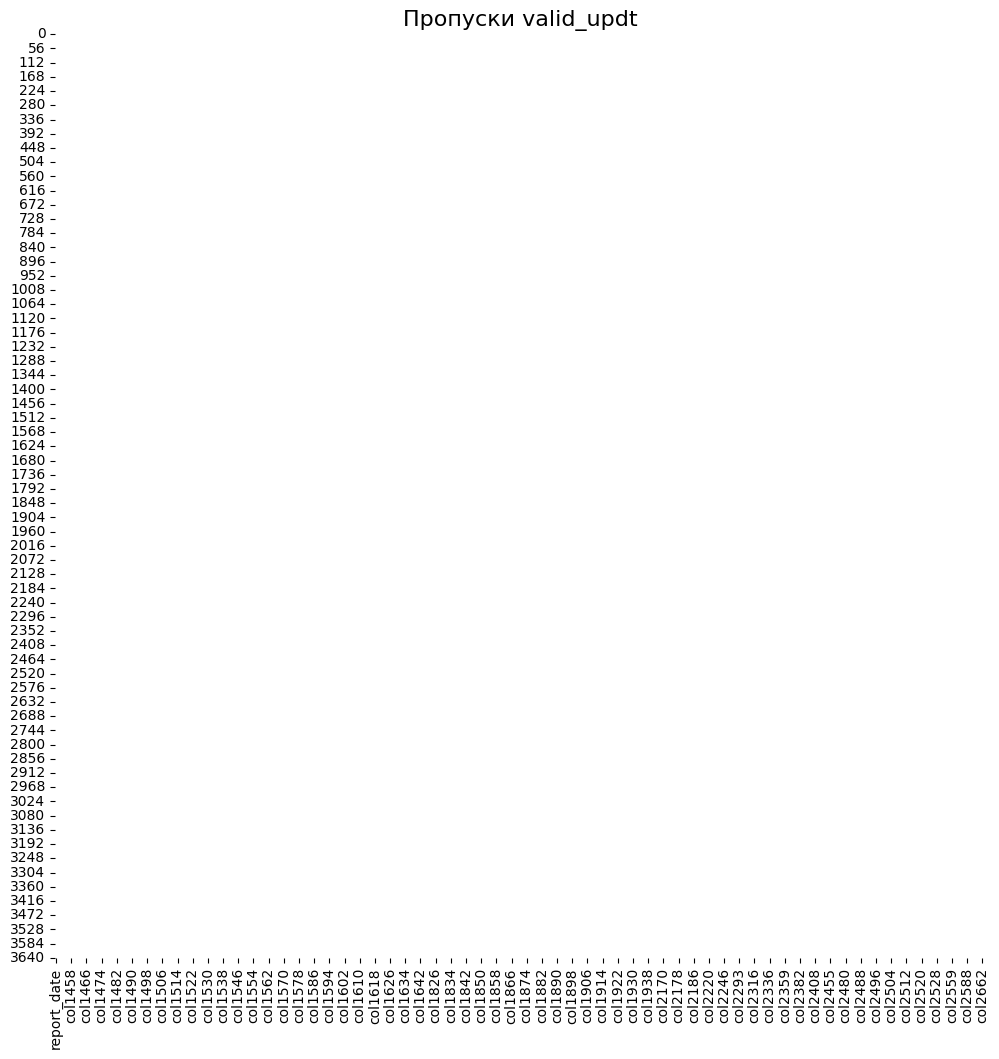

In [206]:
for i, elem in enumerate(arr_updt): 
      fig, ax = plt.subplots(figsize=(12, 12))
      sns.heatmap(elem.isnull(), cbar = False, cmap = 'Greys')
      plt.title(f"Пропуски {names_df_updt[i]}", fontsize=16)
      plt.show()

In [207]:
print(train_updt.isnull().sum())
print()
print(valid_updt.isnull().sum())
print()

train_updt = arr_updt[0]
valid_updt = arr_updt[1]

print(train_updt.isnull().sum())
print()
print(valid_updt.isnull().sum())

report_date       0
client_id         0
target            0
col1453           0
col1454           1
               ... 
col2656        8249
col2660        6420
col2661        6420
col2662        6420
col2663           0
Length: 490, dtype: int64

report_date       0
client_id         0
target            0
col1453           0
col1454           0
               ... 
col2656        2604
col2660        1280
col2661        1280
col2662        1280
col2663           0
Length: 490, dtype: int64

report_date    0
client_id      0
target         0
col1453        0
col1454        0
              ..
col2656        0
col2660        0
col2661        0
col2662        0
col2663        0
Length: 490, dtype: int64

report_date    0
client_id      0
target         0
col1453        0
col1454        0
              ..
col2656        0
col2660        0
col2661        0
col2662        0
col2663        0
Length: 490, dtype: int64


Обучение модели с помощью RandomForestClassifier

In [221]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

X = train_updt.drop(columns=['client_id', 'target', 'report_date'])
y = train_updt['target']

X_valid = valid_updt.drop(columns=['client_id', 'target', 'report_date'], errors='ignore')
y_valid = valid_updt['target']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

X[categorical_features] = X[categorical_features].astype(str)

X_valid[categorical_features] = X_valid[categorical_features].astype(str)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model.fit(X_train, y_train)
print()

Тестируем модель RandomForest

In [222]:
test_preds = model.predict_proba(X_test)[:, 1]
test_score = roc_auc_score(y_test, test_preds)
print(f"ROC-AUC на train данных: {test_score:.4f}")

#########################################################################################

valid_preds = model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, valid_preds)
print(f"ROC-AUC на valid данных: {valid_score:.4f}")

ROC-AUC на train данных: 0.9429
ROC-AUC на valid данных: 0.7064


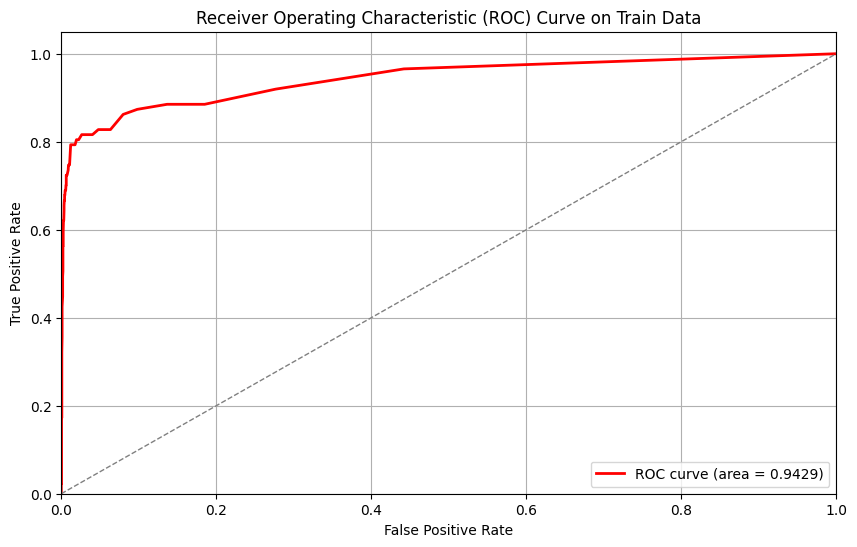

In [223]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, test_preds):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Диагональная линия
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Train Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

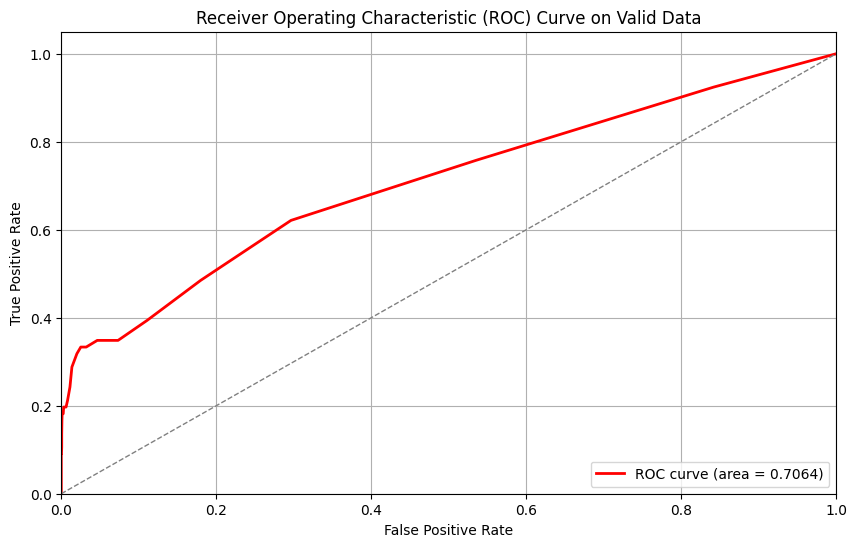

In [224]:
fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_preds)

plt.figure(figsize=(10, 6))
plt.plot(fpr_valid, tpr_valid, color='red', lw=2, label=f'ROC curve (area = {roc_auc_score(y_valid, valid_preds):.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Диагональная линия для случайной модели
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve on Valid Data')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Тестируем модель xgboost

In [225]:
from xgboost import XGBClassifier

# Преобразование данных
X_train_transformed = preprocessor.fit_transform(X_train)
X_valid_transformed = preprocessor.transform(X_valid)  
X_test_transformed = preprocessor.transform(X_test)

# Создание и обучение модели XGBoost
model = XGBClassifier(scale_pos_weight=len(y_train) / sum(y_train == 1),
                      random_state=42,
                      eval_metric='logloss',
                      max_depth=30,
                      n_estimators=500,
                      learning_rate=0.1)

model.fit(X_train_transformed, y_train)

# Прогнозирование на тестовом наборе
y_pred_xgb_test = model.predict(X_test_transformed)
y_pred_prob_xgb_test = model.predict_proba(X_test_transformed)[:, 1]

# Оценка на тестовом наборе
roc_auc_test = roc_auc_score(y_test, y_pred_prob_xgb_test)
print(f"ROC-AUC на train данных: {roc_auc_test:.4f}\n")

# ROC-кривая для тестового набора
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_xgb_test)

#########################################################################################

# Прогнозирование на валидационном наборе
y_pred_xgb_valid = model.predict(X_valid_transformed)
y_pred_prob_xgb_valid = model.predict_proba(X_valid_transformed)[:, 1]

# Оценка на валидационном наборе
roc_auc_valid = roc_auc_score(y_valid, y_pred_prob_xgb_valid)
print(f"ROC-AUC на valid данных: {roc_auc_valid:.4f}")

# ROC-кривая для валидационного набора
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_pred_prob_xgb_valid)

ROC-AUC на train данных: 0.9543

ROC-AUC на valid данных: 0.7652


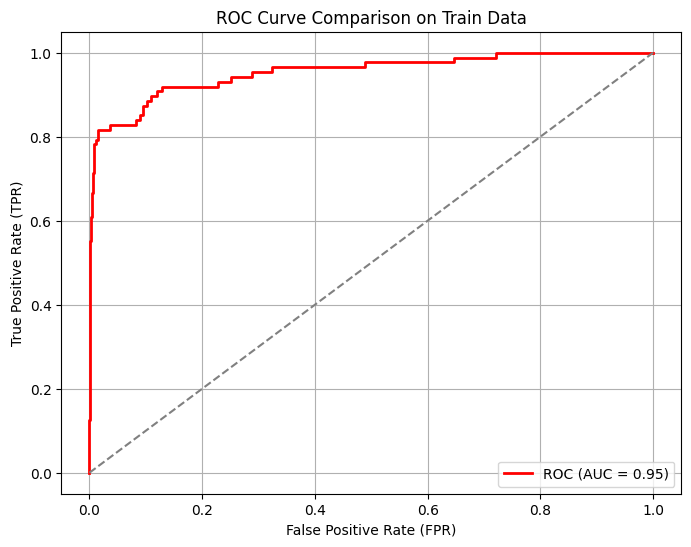

In [226]:
# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Случайная классификация
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison on Train Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

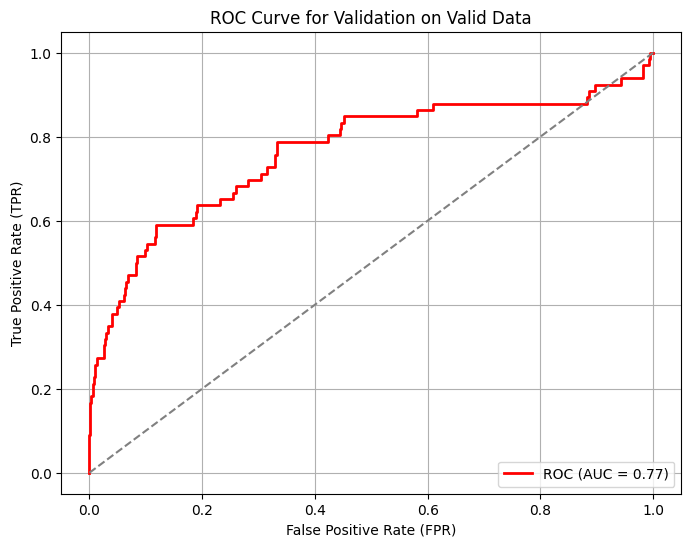

In [227]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_valid, tpr_valid, color='red', lw=2, label=f'ROC (AUC = {roc_auc_valid:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Случайная классификация
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Validation on Valid Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()